In [1]:
print('coucou')

coucou


# Preparatory work

## Derivatives of simple function with one input

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

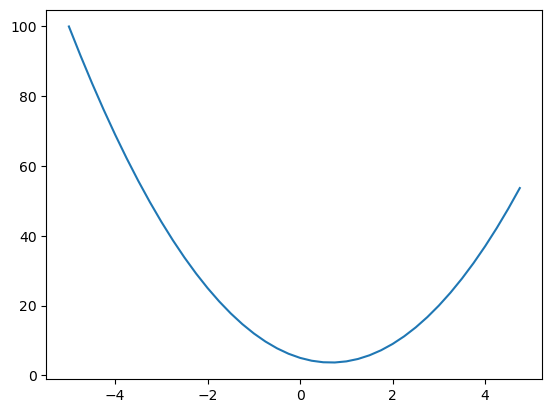

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x))/h

2.9753977059954195e-07

## Derivative of a function with multiple inputs

In [7]:
h =0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
c += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Value object and its visualization

In [41]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):# self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):# self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):# self ** other
        assert isinstance(other, (int, float)), "only supporting int/float powers for now" 
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):# other * self
        return self * other
    
    def __truediv__(self, other):# self / other
        return self * other**-1
    
    def __neg__(self):# -self
        return self * -1
    
    def __sub__(self, other):# self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        topo
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e+c; d.label='d'
f = Value(-2.0, label='f')
L = d*f; L.label='L'

In [9]:
!pip install graphviz
from graphviz import Digraph

def trace(root):
    # build nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root): 
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is the result of an operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

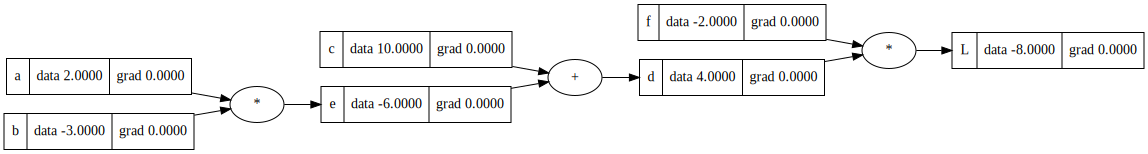

In [10]:
draw_dot(L)

## Manual backpropagation

In [11]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data
    
    a = Value(2.0 , label='a')
    b = Value(-3.0 , label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)
    
lol()

0.0


In [12]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [13]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label='e'
d = e+c; d.label='d'
L = d*f; L.label='L'

print(L.data)

-7.286496


## Manual backpropagation on a neuron

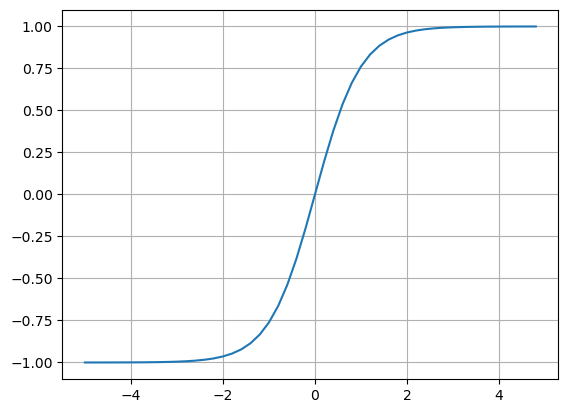

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [15]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

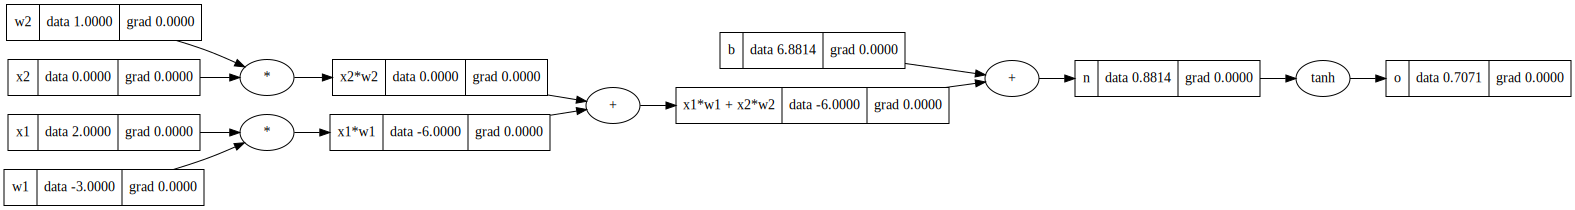

In [16]:
draw_dot(o)

In [17]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## Implementing the backward fonction

In [18]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [19]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

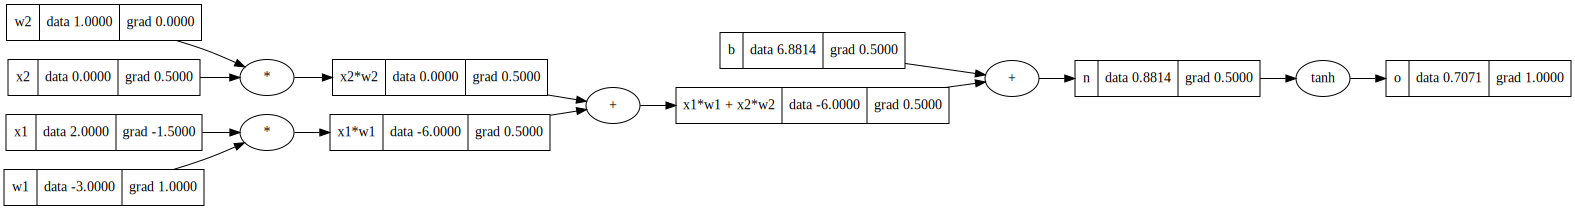

In [20]:
draw_dot(o)

## Implementing the backward function for a whole expression

In [21]:
o.backward()

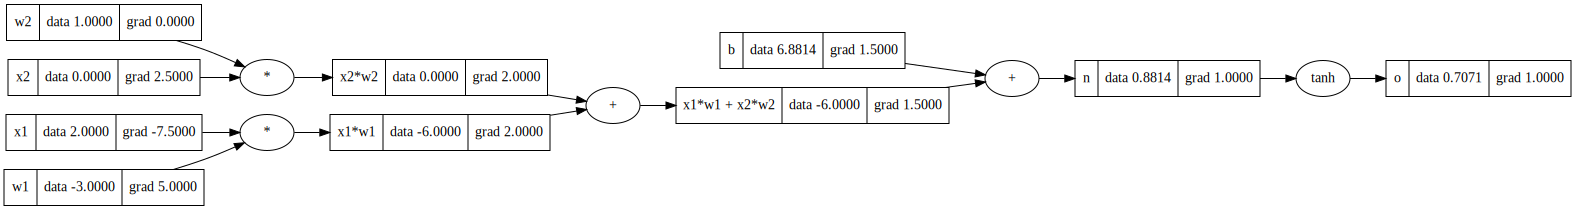

In [22]:
draw_dot(o)

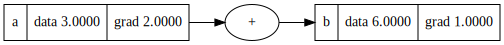

In [23]:
a = Value(3.0, label='a')
b =a+a; b.label = 'b'
b.backward()
draw_dot(b)

## More operations

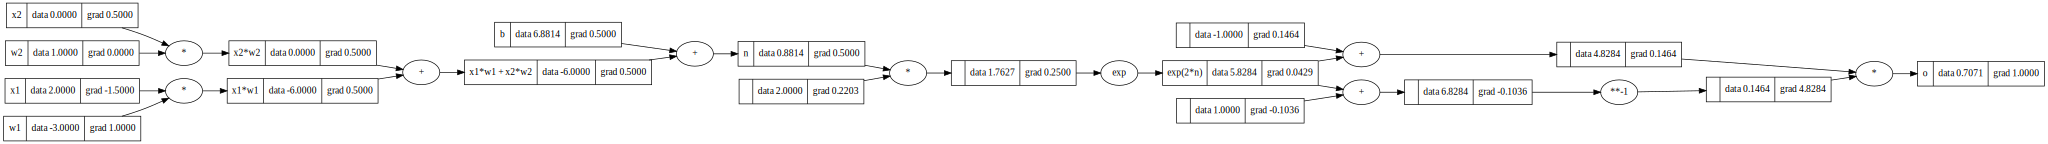

In [24]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'exp(2*n)'
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()
draw_dot(o)

## Pytorch comparison

In [25]:
!pip install torch

In [26]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8814]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071200415967962
---
x2 0.49998124677214517
x1 -1.4999437403164355
w1 0.9999624935442903
w2 0.0


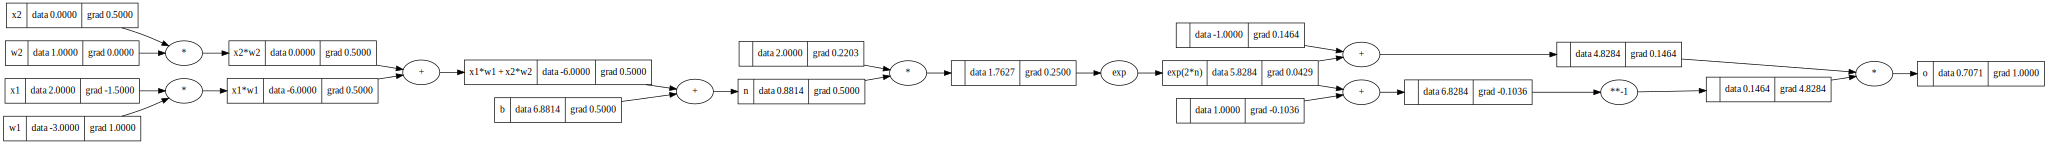

In [27]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.88137, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'exp(2*n)'
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()
draw_dot(o)

## Building a multi-layer perceptron

In [69]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0, 1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.856915691814202)

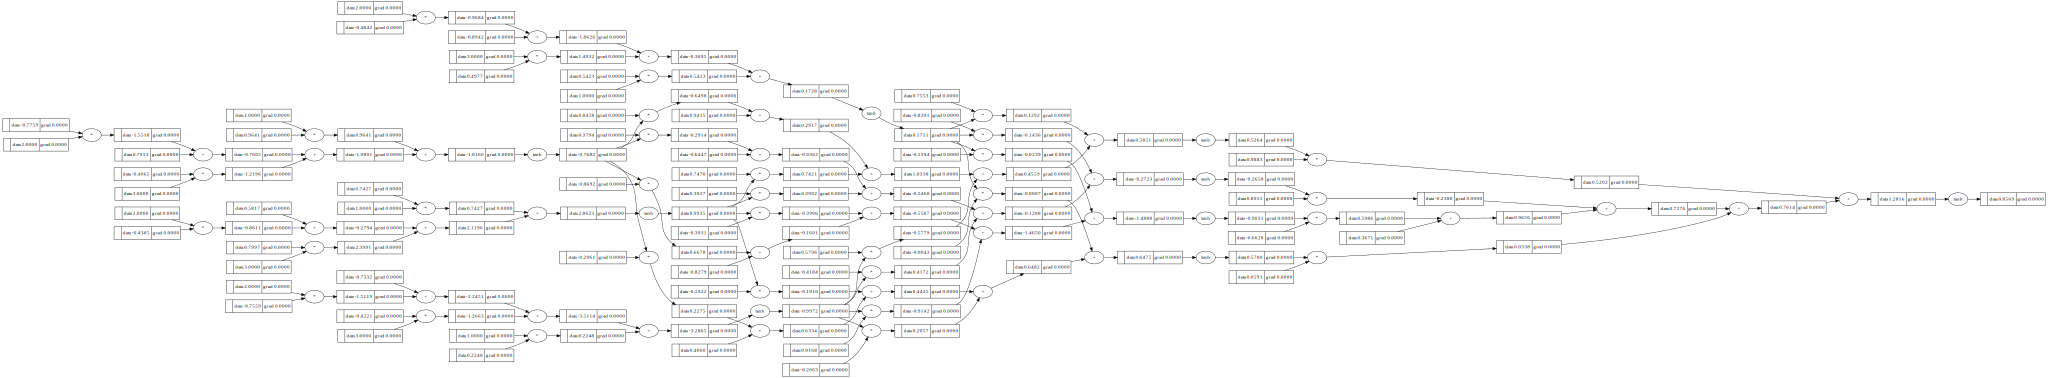

In [70]:
draw_dot(n(x))